In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import pickle

PATH = 'AD Data'

2024-10-16 15:49:51.720913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 15:49:51.729387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 15:49:51.738380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 15:49:51.741082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 15:49:51.748325: I tensorflow/core/platform/cpu_feature_guar

Class distribution before splitting:
Non Demented: 13000 samples
Very mild Dementia: 13000 samples


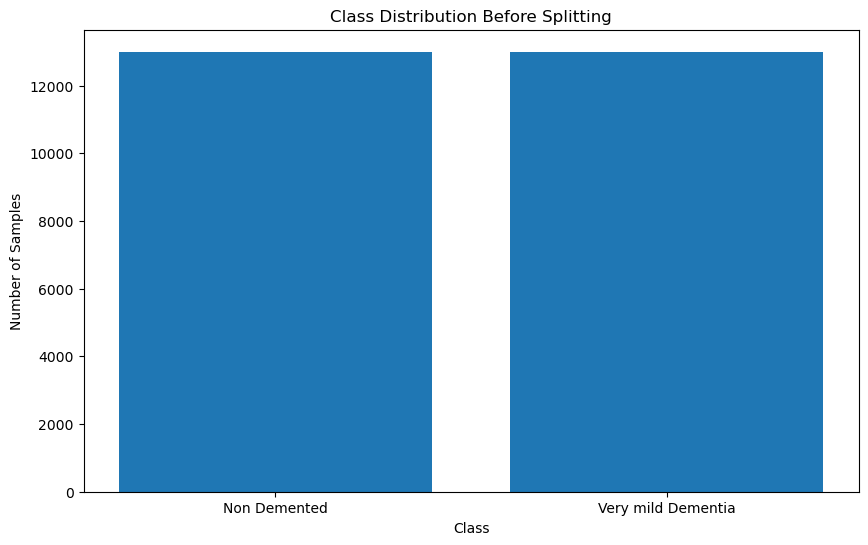

I0000 00:00:1729055992.638568   27266 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729055992.664625   27266 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729055992.664761   27266 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729055992.665671   27266 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Number of training samples: 26000


2024-10-16 15:49:56.706783: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


dataset dataset saved successfully.


In [2]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

#create dataset
def create_dataset(file_paths, labels, batch_size=32, img_size=(224, 224)):
    # Read and decode images
    def load_and_preprocess_image(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, img_size)
        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# save filenames and subjects
data_dir = 'AD Data'
class_names = ['Non Demented', 'Very mild Dementia']

# store subjects
subject_mapping = {}
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        subject_id = filename.split('_')[0]
        if subject_id not in subject_mapping:
            subject_mapping[subject_id] = []
        subject_mapping[subject_id].append(os.path.join(class_dir, filename))

# sample 13,000 images per class
limited_subject_mapping = {}
for class_name in class_names:
    class_paths = [path for subject_id, paths in subject_mapping.items() for path in paths if class_name in path]
    if len(class_paths) > 13000:
        limited_subject_mapping[class_name] = np.random.choice(class_paths, 13000, replace=False)
    else:
        limited_subject_mapping[class_name] = class_paths

# convert the subject mapping to lists
file_paths = []
labels = []
for class_name, paths in limited_subject_mapping.items():
    label = class_names.index(class_name)  # Extract label from class name
    file_paths.extend(paths)
    labels.extend([label] * len(paths))

# Check class distribution before splitting
class_counts = Counter(labels)
print("Class distribution before splitting:")
for class_index, count in class_counts.items():
    print(f"{class_names[class_index]}: {count} samples")

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Splitting')
plt.show()

# Split the data by subjects
file_paths_train, file_paths_temp, labels_train, labels_temp = train_test_split(file_paths, labels, test_size=0.4, stratify=labels)
file_paths_val, file_paths_test, labels_val, labels_test = train_test_split(file_paths_temp, labels_temp, test_size=0.5, stratify=labels_temp)

# Create TensorFlow datasets
batch_size = 32
img_size = (224, 224)
full_dataset = create_dataset(file_paths, labels, batch_size, img_size)
train_dataset = create_dataset(file_paths_train, labels_train, batch_size, img_size)
val_dataset = create_dataset(file_paths_val, labels_val, batch_size, img_size)
test_dataset = create_dataset(file_paths_test, labels_test, batch_size, img_size)

def count_samples(dataset):
    """
    Counts the number of samples in the given dataset.
    """
    count = 0
    for images, labels in dataset:
        count += images.shape[0]
    return count



def save_dataset(dataset, save_dir, dataset_name):
    os.makedirs(save_dir, exist_ok=True)
    
    images, labels = [], []
    
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    np.save(os.path.join(save_dir, f"{dataset_name}_images.npy"), images)
    np.save(os.path.join(save_dir, f"{dataset_name}_labels.npy"), labels)
    
    print(f"{dataset_name} dataset saved successfully.")

# make sure the dataset is properly saved


num_full_samples = count_samples(full_dataset)

print(f"Number of training samples: {num_full_samples}")

save_dataset(full_dataset, 'saved_datasets', 'dataset')

In [3]:
import numpy as np
import os

def load_dataset(save_dir, dataset_name):
    images_path = os.path.join(save_dir, f"{dataset_name}_images.npy")
    labels_path = os.path.join(save_dir, f"{dataset_name}_labels.npy")
    
    #Load the images and labels from the  npy files
    images = np.load(images_path)
    labels = np.load(labels_path)
    
    print(f"{dataset_name} dataset loaded successfully.")

    return images, labels

# Load the dataset. Make sure its loaded properly:
images, labels = load_dataset('saved_datasets', 'dataset')
print(f"Loaded {images.shape[0]} images with shape {images.shape[1:]} and {labels.shape[0]} labels.")

dataset dataset loaded successfully.
Loaded 26000 images with shape (224, 224, 3) and 26000 labels.


In [4]:
import keras_tuner as kt
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D

def build_model():


    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (224,224,3)))

    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4,activation='softmax'))
    return model

In [5]:
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [6]:
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
# Parameters for cross-validation
num_folds = 15
validation_scores = []

# Set up KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Reshape images and labels for KFold splitting
file_paths = np.array(file_paths)  # Make sure file_paths is a numpy array
labels = np.array(labels)

for fold, (train_index, val_index) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold + 1} / {num_folds}...")

    # Split into training and validation sets
    file_paths_train, file_paths_val = file_paths[train_index], file_paths[val_index]
    labels_train, labels_val = labels[train_index], labels[val_index]

    # Create TensorFlow datasets
    train_dataset = create_dataset(file_paths_train, labels_train, batch_size, img_size)
    val_dataset = create_dataset(file_paths_val, labels_val, batch_size, img_size)
    
    # Reinitialize the model at the start of each fold
    model = build_model()
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor="val_loss",
        min_delta=0.00001,
        patience=20,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0,
    )
    
    # Train the model on the training set and validate on the validation set for this fold
    history = model.fit(
        train_dataset,
        epochs=5,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        batch_size=128,
        verbose=1
    )
    
    # Evaluate the model on the validation set and record the validation accuracy
    val_loss, val_accuracy = model.evaluate(val_dataset)
    validation_scores.append(val_accuracy)
    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy}")
    
    # Clear the Keras session after each fold to free memory
    K.clear_session()

# Print cross-validation results
mean_val_accuracy = np.mean(validation_scores)
std_val_accuracy = np.std(validation_scores)
print(f"Mean Validation Accuracy across {num_folds} folds: {mean_val_accuracy}")
print(f"Standard Deviation of Validation Accuracy: {std_val_accuracy}")


Training fold 1 / 15...


/home/kathy/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


I0000 00:00:1729056061.095845   30541 service.cc:146] XLA service 0x7e2ad8003a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729056061.095866   30541 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-10-16 15:51:01.129090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 15:51:01.424537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  5/759 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.5861 - loss: 2.1101 

I0000 00:00:1729056083.650288   30541 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


759/759 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - accuracy: 0.9900 - loss: 1.8772 - val_accuracy: 0.4873 - val_loss: 545.0659
Epoch 2/5
759/759 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9746 - loss: 17.8679 - val_accuracy: 0.4873 - val_loss: 7724.4902
Epoch 3/5
759/759 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9552 - loss: 352.3641 - val_accuracy: 0.4873 - val_loss: 122.7402
Epoch 4/5
759/759 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9582 - loss: 6.6149 - val_accuracy: 0.4896 - val_loss: 33.1936
Epoch 5/5
759/759 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.8270 - loss: 2.2418 - val_accuracy: 0.4902 - val_loss: 13.5202
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1633 - loss: 22.0858
Fold 1 - Validation Accuracy: 0.4901960790157318
Training fold 2 / 15...
Epoch 1/5
759/759 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.9902 - loss: 1.4699 - val_accuracy: 0.4764 - val_loss: 933.5104
Epoch 2/5
759/759 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.9690 - l

In [7]:
model.evaluate(test_dataset)


163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4977 - loss: 295.2359


[293.3357238769531, 0.5009615421295166]